In [1]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns

функция One_Hot_Encoding

In [2]:
def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACGUN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'U':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

загрузим датасет с бинами и преобразуем

In [4]:

data = pd.read_csv('20long.csv') # сразу загружается таблица бинов
data["label"] = 0


for i in range(len(data.columns)-3):
    
    data.loc[data[f'F{i+1} probability'] > 0.6, "label"] = i
    

data.loc[data['F7 probability'] > 0.6, "label"] = 6 
data.loc[data['F8 probability'] > 0.6, "label"] = 6
data.label = data.label.astype(int)

#print(data[data["label"] == 1].shape)

prob = data[["seq","label"]]


представленность классов и количества в классах по всем имеющимся данным

In [7]:
for i in range(7):
    pr = f"F{i+1} :    "
    
    if i == 6:
        pr = pr = f"F78 :   "
        
    print(pr,i,prob[prob[prob.columns[1]] == i].shape)

F1 :     0 (1878, 2)
F2 :     1 (1933, 2)
F3 :     2 (2158, 2)
F4 :     3 (1798, 2)
F5 :     4 (1376, 2)
F6 :     5 (1471, 2)
F78 :    6 (1078, 2)


функция разделения данных на train test

In [9]:
def quick_split(df, split_frac=0.8, verbose=False):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''
    cols = df.columns # original columns, use to clean up reindexed cols
    df = df.reset_index()

    # shuffle indices
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]

разделим данные на train, val, test

In [10]:
full_train_df, test_df = quick_split(prob)
train_df, val_df = quick_split(full_train_df)

итого данных получилось в каждом наборе:

In [11]:
print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (7482, 2)
Val: (1871, 2)
Test: (2339, 2)


Train содержит 7482 записей, Val - 1871 записей, Test - 2339 записей

посмотрим представленность данных в датасете train

In [19]:
for i in range(7):
    pr = f"F{i+1} :    "
    
    if i == 6:
        pr = f"F78 :   "
        
    print("Train_dataframe, Class ", pr, "label: ", i, train_df[train_df[train_df.columns[1]] == i].shape)


Train_dataframe, Class  F1 :     label:  0 (1208, 2)
Train_dataframe, Class  F2 :     label:  1 (1225, 2)
Train_dataframe, Class  F3 :     label:  2 (1370, 2)
Train_dataframe, Class  F4 :     label:  3 (1149, 2)
Train_dataframe, Class  F5 :     label:  4 (894, 2)
Train_dataframe, Class  F6 :     label:  5 (933, 2)
Train_dataframe, Class  F78 :    label:  6 (703, 2)


In [15]:
print(train_df)

                          seq  label
2     CACAUAACUGGAGACACAGCAUG      6
5     AGAGAUAGAGGAGGAUUAAAAUG      6
6     AGAGAAAGAGGAGGGCAAAGAUG      6
7     AUAUGGUGGAGGAAAUAGUCAUG      6
9     GUAUGAAGAGGAGAAAAGGUAUG      6
...                       ...    ...
9347  AGAAUAACUGGAGGAGGAAAAUG      5
9348  AUUCAUGGGUGAGAAAAUAUAUG      5
9349  GUUAUUAAAAGAGAGCAAACAUG      5
9351  UGCUACAGAAUAAUUACAAGAUG      5
9352  UUAUCAUUGAAGGUAUACAUAUG      5

[7482 rows x 2 columns]


создадим датасет OHE - actual Y

In [20]:
class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='label'
                ):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values) # лист всех последовательностей
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
        
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)

        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label

In [21]:
def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='label',
                      batch_size=128,
                      shuffle=True
                     ):
    '''
    Given a train and test df with some batch construction
    details, put them into custom SeqDatasetOHE() objects. 
    Give the Datasets to the DataLoaders and return.
    '''
    
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    
    return train_dl,test_dl

In [22]:
train_dl, val_dl = build_dataloaders(train_df, val_df)

### визуализация лосса

In [30]:
def quick_loss_plot(data_label_list,loss_type="BCE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Val",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

### создание датасета Seq - predicted - actual

используется для проверки модели на тестовых данных 

выдаёт датафрейм и вектор содержащий предсказанные значения( для удобства, чтобы можно было выбрать например все предсказанные значения для последнего бина y_pred[:, 6])

In [47]:
def quick_seq_pred(model, seqs, oracle):
    '''
    Given a model and some sequences, get the model's predictions
    for those sequences and compare to the oracle (true) output
    
    '''
    vect = []
    df = pd.DataFrame(data = {'seq': [], 'pred': [], 'actual': []})
    
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)# One_Hot_Encode
        #model.train(False)
        
        pred = model(s.float()) # model predicted value
    
        actual = oracle[dna] # actual value        
        
        df = df.append({'seq': dna, 'pred': pred.cpu().detach().numpy()[0], 'actual': actual}, ignore_index = True)
        
        # вектор из предсказанных векторов передаём отдельно; костыль, чтобы данные подходили по размерности
        vect.append(pred.cpu().detach().numpy()[0])
        y_pred = np.asarray(vect)
        
    return df, y_pred
    

## Small_CNN

In [23]:
class Small_CNN(nn.Module):
    def __init__(self,
                seq_len,
                block_sizes=[16, 24, 32, 40, 48],
                kernel_size=7):
        
        super().__init__()
        self.seq_len = seq_len
      
        nn_blocks = []
      
        for in_bs, out_bs in zip([4] + block_sizes, block_sizes):
            
            block = nn.Sequential(
                nn.Conv1d(in_bs, out_bs, kernel_size=kernel_size, padding=1),
                nn.Sigmoid(),
                nn.BatchNorm1d(out_bs)
            )
            
            nn_blocks.append(block)
            
        self.conv_net = nn.Sequential(
            *nn_blocks,
            nn.Flatten(),
            nn.Linear(block_sizes[-1] * (seq_len + len(block_sizes)*(3-kernel_size)), 7),
        )

    def forward(self, x):
        # reshape view to batch_size x 4channel x seq_len
        # permute to put channel in correct order
        x = x.permute(0,2,1) 
        
        out = self.conv_net(x)
        
        return out
    

## evaluate

In [24]:
def evaluate(model, dataloader, loss_fn):
    
    losses = []

    for i, batch in enumerate(dataloader):
        
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        with torch.no_grad():
            #print(X_batch[0])
            #print(X_batch[0].shape)
            logits = model(X_batch.to(device).float())
            #print(logits)
            #print(logits.shape)
            loss = loss_fn(logits, y_batch.long().squeeze(1).to(device))
            losses.append(loss.item())
            
    return np.mean(losses)



## train

In [77]:
def train(model,train_dataloader, val_dataloader, loss_fn, optimizer, n_epoch=3):
    
    train_losses = []
    val_losses = []
    
    
    # цикл обучения сети
    for epoch in range(n_epoch):

        model.train(True)
        
        running_losses = []
        running_accuracies = []
        
        
        for i, batch in enumerate(train_dataloader):
            # так получаем текущий батч
            X_batch, y_batch = batch 
            
            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device).float()) 
            #print(y_batch.long().squeeze(1).to(device))
            #print(y_batch.long().to(device))
            #print(logits)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.long().squeeze(1).to(device)) 
            running_losses.append(loss.item())
            
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса
            

        model.train(False)
        
        train_loss = np.mean(running_losses)
        
        val_loss = evaluate(model, val_dataloader, loss_fn=loss_fn)
    
        #print(f"E{epoch+1} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
    return train_losses, val_losses

## объявление модели

только для 30 эпох( поэтому называется model30)

In [64]:
seq_len = len(train_df['seq'].values[0])

# объявим модель
model30 = Small_CNN(seq_len)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model30 = model30.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate. 
learning_rate = 1e-3
optimizer = torch.optim.AdamW(model30.parameters(), weight_decay = 0.1, lr=learning_rate)

In [65]:
# запустим обучение модели
cnn_train_losses, cnn_val_losses = train(model30, train_dl, val_dl, loss_fn, optimizer, n_epoch=30)

отрисуем лосс

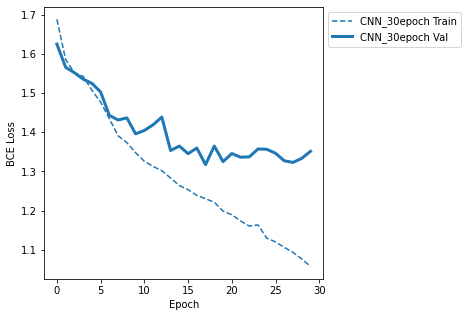

In [66]:
cnn_data_label = (cnn_train_losses,cnn_val_losses,"CNN_30epoch")
quick_loss_plot([cnn_data_label])

переобучение еще не началось

#### проверим на тестовых данных

In [67]:
# тут собирается словарь для тестовой выборки для использования в quick seq pred
oracle = dict(test_df[['seq','label']].values)

test_quick30, y_pred30 = quick_seq_pred(model30, oracle.keys(), oracle)

test_quick30 - датафрейм содержащий значения предсказанные и актуальные: pred _ actual

y_pred_30 - вектор предсказанных значений, чисто для удобства в последующей визуализации

как выглядит вектор y_pred30:

In [68]:
y_pred30[:5]

array([[ 0.27931693, -4.0814466 , -2.617274  , -1.6447498 ,  0.20728754,
         1.9781518 ,  5.4791355 ],
       [ 0.43770254, -4.5689306 , -3.4467247 , -1.6056422 , -0.0263545 ,
         2.984191  ,  6.3408117 ],
       [ 1.7003958 ,  2.3631046 ,  1.0271953 , -0.97850096, -0.7668788 ,
        -1.3219533 , -2.7116654 ],
       [ 0.44162303, -3.8574207 , -3.3358371 , -1.6356225 ,  0.18204771,
         2.8102133 ,  5.7226057 ],
       [-1.1757945 ,  0.7927771 ,  1.7438171 ,  2.6933486 ,  0.86474496,
        -2.1105704 , -3.8408887 ]], dtype=float32)

### отрисовка кривой roc_auc

In [78]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

def graph_roc_multiclass(df,y_pred,n_classes = 7):
    
    y_true=df["actual"]
    y_score=y_pred

    y = label_binarize(y_true, classes=[0,1,2,3,4,5,6])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    lw = 1
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['orange', 'green', 'red', 'purple', 'brown', 'pink', 'blue'])

    # Plot of a ROC curve for a specific class
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw= 0.5,label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.rcParams['figure.figsize'] = [5,5]
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()

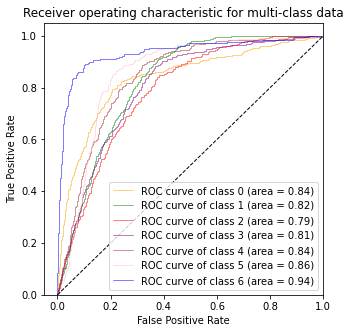

In [69]:
graph_roc_multiclass(test_quick30, y_pred30, n_classes = 7)

### проведём те же манипуляции для 100 эпох

In [70]:
# снова объявим модель
model100 = Small_CNN(seq_len)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model100 = model100.to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate. 
learning_rate = 1e-3
optimizer = torch.optim.AdamW(model100.parameters(), weight_decay = 0.1, lr=learning_rate)

In [71]:
# запустим обучение модели для 100 эпох
cnn_train_losses100, cnn_val_losses100 = train(model100, train_dl, val_dl, loss_fn, optimizer, n_epoch=100)

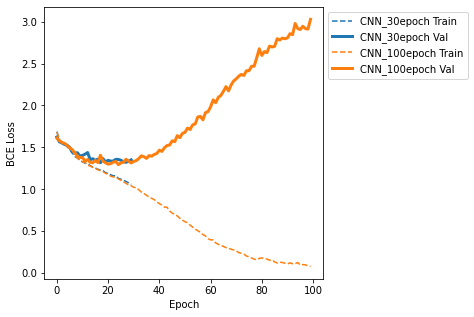

In [72]:
cnn_data_label100 = (cnn_train_losses100, cnn_val_losses100,"CNN_100epoch")
quick_loss_plot([cnn_data_label, cnn_data_label100])

данные с переобчуением после 30-ой эпохи

In [73]:
oracle = dict(test_df[['seq','label']].values)

test_quick100, y_pred100 = quick_seq_pred(model100, oracle.keys(), oracle)

In [75]:
y_pred100[0:5]

array([[ -4.0469913 ,  -4.862878  ,  -7.401893  ,  -3.8722494 ,
          1.8394687 ,   4.3855004 ,   9.870638  ],
       [ -0.7308663 ,  -5.9675465 ,  -3.7779179 ,   0.01728358,
         -5.639479  ,   5.0295615 ,   8.427893  ],
       [ -0.364802  ,   2.4634314 ,   3.3857923 ,  -0.31683287,
          2.1659198 ,  -1.6644447 ,  -4.735626  ],
       [  2.9538975 , -13.80311   ,  -4.379549  ,  -1.5196368 ,
         -8.986362  ,   5.1153874 ,  16.327635  ],
       [ -3.8015244 ,  -1.4340092 ,   2.4570472 ,  -0.67166436,
          6.221301  ,  -0.4351193 ,  -4.036125  ]], dtype=float32)

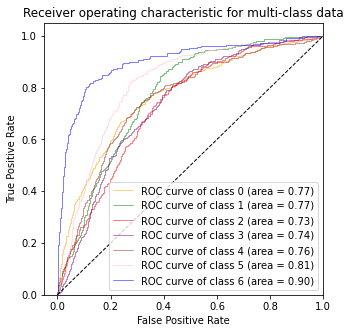

In [74]:
graph_roc_multiclass(test_quick100, y_pred100, n_classes = 7)